# Install packages and dataset

In [1]:
# %pip install -U git+https://github.com/albumentations-team/albumentations
# %pip install --upgrade opencv-contrib-python

In [2]:
# !git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git
# import sys
# sys.path.append('/content/Human-Segmentation-Dataset-master')

## Class Helper

In [3]:
class helper:
    def show_image(image,mask,pred_image = None):
        if pred_image == None:
            
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
            
            ax1.set_title('IMAGE')
            ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
            
            ax2.set_title('GROUND TRUTH')
            ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
            
        elif pred_image != None :
            
            f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
            
            ax1.set_title('IMAGE')
            ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
            
            ax2.set_title('GROUND TRUTH')
            ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
            
            ax3.set_title('MODEL OUTPUT')
            ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
     

# Includes

In [4]:
import torch 
import cv2
import sys

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

import albumentations as A

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss, TverskyLoss, JaccardLoss
from sklearn.model_selection import train_test_split
from tqdm import tqdm
torch.cuda.empty_cache()

# Setup Configurations

In [5]:
CSV_FILE = 'C:\\Users\\davii\\OneDrive\\Escritorio\\Cursos\\image_segmentation\\Human-Segmentation-Dataset-master\\train.csv'
DATA_DIR = 'C:\\Users\\davii\\OneDrive\\Escritorio\\Cursos\\image_segmentation\\Human-Segmentation-Dataset-master'

DEVICE = 'cuda'

EPOCH = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 10

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

## Load data

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[1]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.

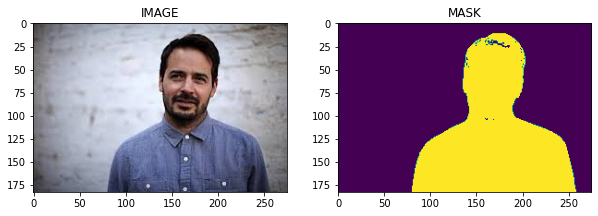

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('IMAGE')
ax1.imshow(image);

ax2.set_title('MASK')
ax2.imshow(mask);

## Split train

In [9]:
train_df, valid_df = train_test_split(df, test_size =.2, random_state = 42)

# Data Augmentation

In [10]:
def get_train_augmentations():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=.5),
        A.VerticalFlip(p=.5)
    ])
def get_valid_augmentations():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    ])
    

# Custom Dataset

In [11]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations
    
    def __len__(self):
        return(len(self.df))

    def __getitem__(self, index):
        row = self.df.iloc[index]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # shape (h, w, c)
        mask = np.expand_dims(mask, axis = -1)

        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            image = data['image']
            mask = data['mask']
        
        #(h, w, c) -> (c, h, w)
        image = np.transpose(image, (2,0,1)).astype(np.float32) # put c on the first position
        mask = np.transpose(mask, (2,0,1)).astype(np.float32) # put c on the first position

        image = torch.Tensor(image) / 255.
        mask = torch.round(torch.Tensor(mask) / 255.) # round mask 0 to 1
    
        return image, mask



In [12]:
trainset = SegmentationDataset(train_df, get_train_augmentations())
validset = SegmentationDataset(valid_df, get_valid_augmentations())

print("Size of Trainset: ", len(trainset))
print("Size of Validset: ", len(validset))

Size of Trainset:  232
Size of Validset:  58


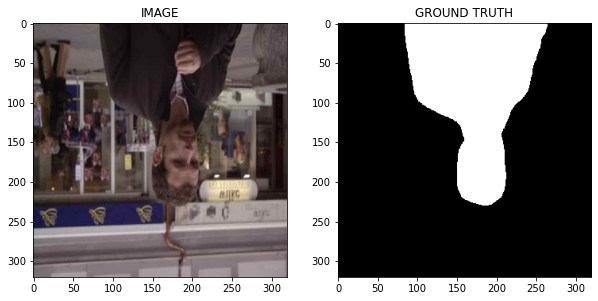

In [13]:
index = 75
image, mask = trainset[index]
helper.show_image(image, mask)

# Load Dataset into batches

In [14]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

print("Batches of Trainloader: ",len(trainloader))
print("Batches of Validloader: ",len(validloader))

Batches of Trainloader:  24
Batches of Validloader:  6


In [15]:
for image, mask in trainloader: 
    break
print("One batch image shape: ", image.shape)
print("One batch mask shape: ", mask.shape)

One batch image shape:  torch.Size([10, 3, 320, 320])
One batch mask shape:  torch.Size([10, 1, 320, 320])


# Segmentation model

In [16]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3, 
            classes = 1,
            activation = None
        )
    def forward(self, images, masks = None):
        logits = self.arc(images)
        if masks != None:  # If mask doesn't exists, we dont have loss
            loss1 = JaccardLoss(mode='binary')(logits, masks)
            # loss2 = JaccardLoss(logits,masks)
            return logits, loss1 #+ loss2
        return logits

In [17]:
model = SegmentationModel()
model = model.to(DEVICE)

# Train and Validation Function

In [18]:
def train_function(data_loader, model, optimizer):
    model.train()
    total_loss = 0.

    for images, masks in tqdm(data_loader): # tqdm is for progress bar
        # Load data in GPU
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, mask)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    return total_loss/len(data_loader)

In [19]:
def eval_function(data_loader, model):
    model.eval()
    total_loss = 0.

    with torch.no_grad(): # put the grad to false (not use in eval)
        for images, masks in tqdm(data_loader):
            # Load data in GPU
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, mask)
            loss.backward()

            total_loss += loss.item()
        
    return total_loss/len(data_loader)

# Train model

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [21]:
best_valid_loss = np.Inf # infinity

for i in range (EPOCH):
    train_loss = train_function(trainloader, model, optimizer)
    valid_loss = eval_function(validloader, model)
    if validloader < best_valid_loss:
        torch.save(model.state_dict(),'best_model_pytorch')
        print('Saved model ', str(i+1))
        best_valid_loss = valid_loss
    print("Epoch: ",str(i+1), " Train_loss: ", train_loss, " Valid_loss: ", valid_loss)

  0%|          | 0/24 [00:03<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

# Inference

In [ ]:
index = 20
# model.load_state_dict(torch.load(route_best_model.pt))
image, mask = validset[index]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (channel, higth, weight) -> (1,C,H,W) 
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > .5)* 1.

In [ ]:
helper.show_image(image, pred_mask.detach().cpu().squeeze(0))

In [ ]:
print(torch.cuda.current_device())

0


In [ ]:
print("Is cuda available?", torch.cuda.is_available())

print("Is cuDNN version:", torch.backends.cudnn.version())

print("cuDNN enabled? ", torch.backends.cudnn.enabled)

print("Device count?", torch.cuda.device_count())

print("Current device?", torch.cuda.current_device())

print("Device name? ", torch.cuda.get_device_name(torch.cuda.current_device()))


Is cuda available? True
Is cuDNN version: 8302
cuDNN enabled?  True
Device count? 1
Current device? 0
Device name?  NVIDIA GeForce GTX 1050


In [ ]:
tensor(cardCoords)

NameError: name 'tensor' is not defined